BOX 1: reading packages

In [ ]:
import pandas as pd
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare, stats

BOX 2 reading the csv + checking each column for null values

In [8]:
df = pd.read_csv('udemy_database.csv')
has_nulls = df.isnull().any()
print(has_nulls)

course_id              False
course_title           False
url                    False
is_paid                False
price                  False
num_subscribers        False
num_reviews            False
num_lectures           False
level                  False
content_duration       False
published_timestamp    False
subject                False
dtype: bool


BOX 3 checking for duplicates - there where 4 duplicates

In [14]:
course_counts = df['course_id'].value_counts()

duplicates = course_counts[course_counts > 1]
print(duplicates)

df.drop_duplicates(subset='course_id', inplace=True)


Series([], Name: count, dtype: int64)


BOX 3: detecting outliers
method: https://bpb-us-w2.wpmucdn.com/sites.umassd.edu/dist/f/1316/files/2023/01/Statistics-for-Nursing-and-Allied-Health-PDFDrive-.pdf#page=34
Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69

In [31]:
outliers_dict = {}

for column in df.select_dtypes(include=['float64', 'int64']).columns:
    mean = df[column].mean()
    std_dev = df[column].std()

    outliers = df[(df[column] < (mean - 3 * std_dev)) | (df[column] > (mean + 3 * std_dev))]

    outliers_dict[column] = outliers
    outliers_count = len(outliers)
    
    print(f"Column: {column}, Outliers Count: {outliers_count}")
    # print(outliers, "\n")


Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69


BOX 4: the outliers intersection based on numeric variables

In [43]:
common_outliers_pairwise = {}

for col1, col2 in combinations(outliers_dict.keys(), 2):
    outliers_col1 = set(outliers_dict[col1]['course_id']) if isinstance(outliers_dict[col1], pd.DataFrame) else set(outliers_dict[col1])
    outliers_col2 = set(outliers_dict[col2]['course_id']) if isinstance(outliers_dict[col2], pd.DataFrame) else set(outliers_dict[col2])

    common_outliers = outliers_col1.intersection(outliers_col2)

    common_outliers_pairwise[f"{col1} & {col2}"] = common_outliers

for columns, common_outliers in common_outliers_pairwise.items():
    print(f"Common outliers for {columns}:", len(common_outliers))
    for course_id in common_outliers:
        print(f"  - Course ID {course_id}")
    print()



Common outliers for course_id & price: 0

Common outliers for course_id & num_subscribers: 0

Common outliers for course_id & num_reviews: 0

Common outliers for course_id & num_lectures: 0

Common outliers for course_id & content_duration: 0

Common outliers for price & num_subscribers: 0

Common outliers for price & num_reviews: 0

Common outliers for price & num_lectures: 0

Common outliers for price & content_duration: 0

Common outliers for num_subscribers & num_reviews: 20
  - Course ID 764164
  - Course ID 364426
  - Course ID 130064
  - Course ID 519442
  - Course ID 437398
  - Course ID 719002
  - Course ID 405926
  - Course ID 625204
  - Course ID 756150
  - Course ID 446134
  - Course ID 473160
  - Course ID 48841
  - Course ID 289230
  - Course ID 41295
  - Course ID 238934
  - Course ID 314462
  - Course ID 461160
  - Course ID 173548
  - Course ID 705264
  - Course ID 707962

Common outliers for num_subscribers & num_lectures: 10
  - Course ID 764164
  - Course ID 11174
 

BOX 5: plotting the data to better see the outliers

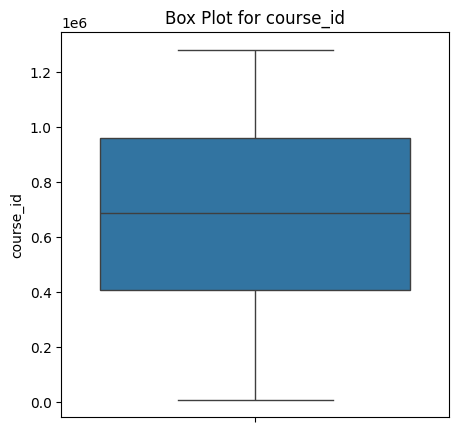

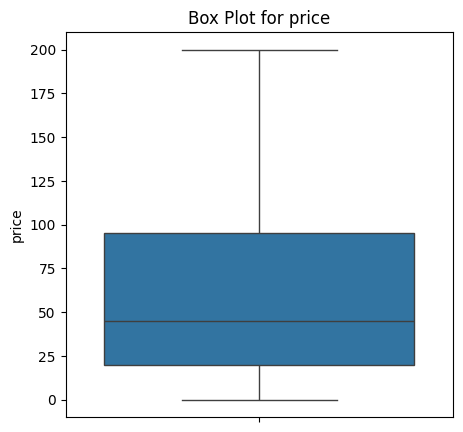

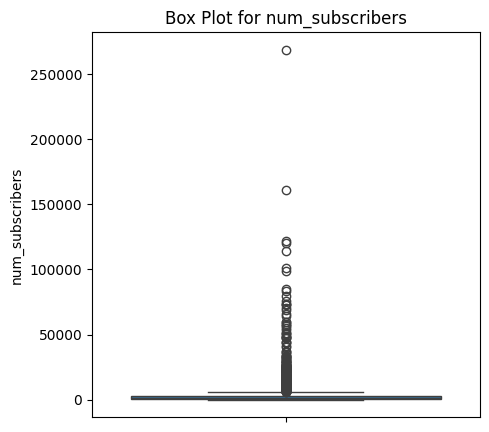

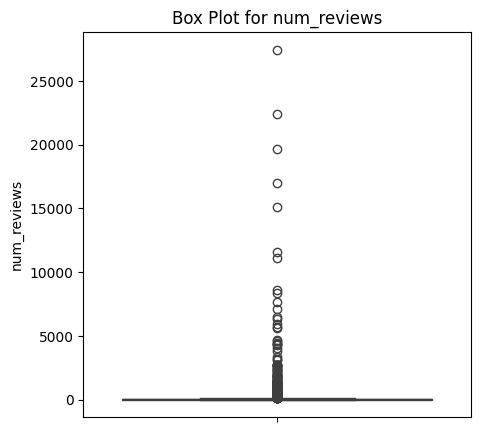

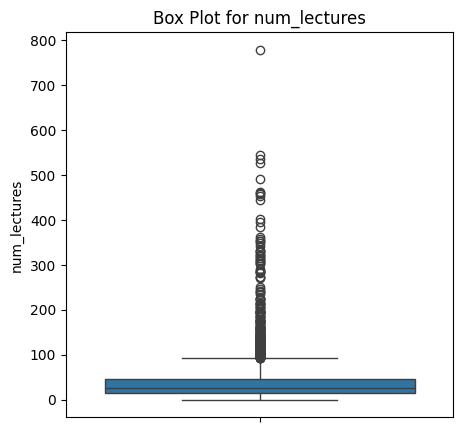

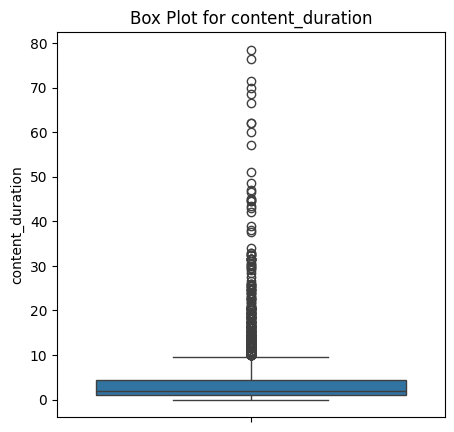

In [47]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

for column in numerical_cols:
    plt.figure(figsize=(5, 5))
    sns.boxplot(y=df[column])  
    plt.title(f'Box Plot for {column}')
    plt.ylabel(column)
    plt.show()

BOX 6 Perform a Chi-Square Test for Goodness of Fit on observed categorical counts.

In [49]:
def chi_square_test(observed_values, alpha=0.05):

    expected_counts = [sum(observed_values) / len(observed_values)] * len(observed_values)

    chi2_stat, p_value = chisquare(f_obs=observed_values, f_exp=expected_counts)

    result = "reject the null hypothesis" if p_value < alpha else "fail to reject the null hypothesis"
    
    # print(f"Chi-Square Statistic: {chi2_stat}")
    # print(f"P-Value: {p_value}")
    # print(f"Result: {result}")

    # print(f"Observed Values: {observed_values}")
    # print(f"Expected Values: {expected_counts}")
    # print(f"Chi-Square Statistic: {chi2_stat}")
    # print(f"P-Value: {p_value}")
    # print(f"Result: {result}")
    
    return {
        f"Chi-Square Statistic: {chi2_stat}",
        f"P-Value: {p_value}",
        f"Result: {result}"
    }

In [ ]:
outliers_dict = {}

for column in df.select_dtypes(include=['float64', 'int64']).columns:
    mean = df[column].mean()
    std_dev = df[column].std()

    outliers = df[(df[column] < (mean - 3 * std_dev)) | (df[column] > (mean + 3 * std_dev))]

    outliers_dict[column] = outliers
    outliers_count = len(outliers)
    
    print(f"Column: {column}, Outliers Count: {outliers_count}")
    # print(outliers, "\n")


Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69


BOX 7 BARCHART: count all the courses taking into account the subject

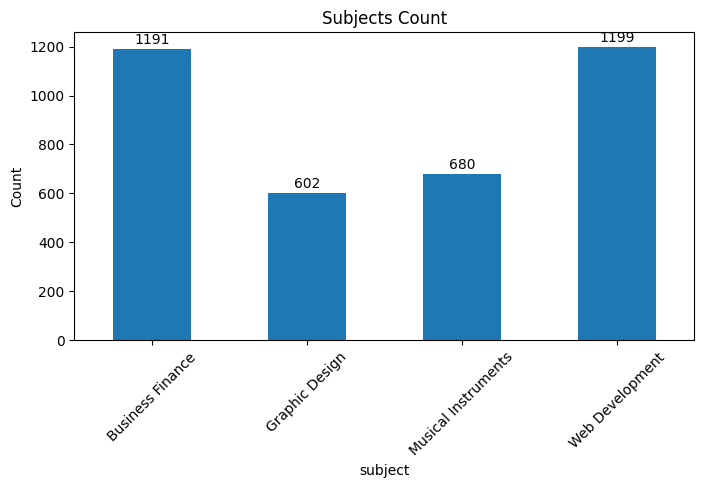

In [52]:
category = df.groupby('subject')['subject'].count()

plt.figure(figsize=(8, 4))
for i, v in enumerate(category.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')
category.plot(kind='bar')
plt.title('Subjects Count')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

BOX 15: Average price for each subject

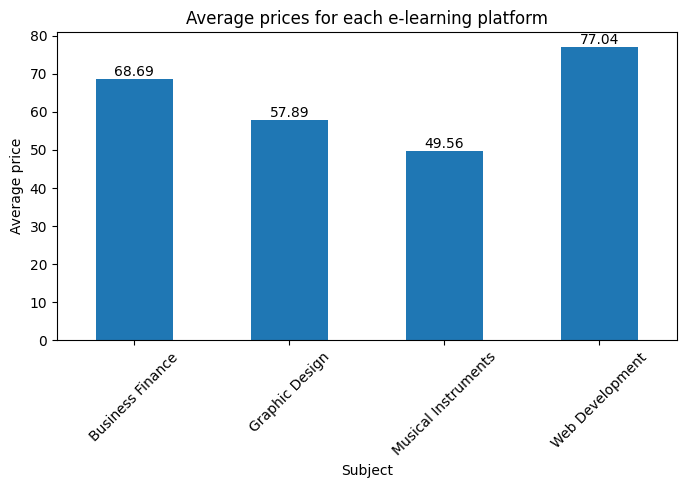

In [ ]:
avg_price = df.groupby('subject')['price'].mean()

plt.figure(figsize=(8, 4) ,linewidth=2)
for i, v in enumerate(avg_price.values):
    plt.text(i, round(v,2) + .05, str(round(v, 2)), ha='center', va='bottom')
avg_price.plot(kind='bar')
plt.title('Average prices for each subject')
plt.xlabel('Subject')
plt.ylabel('Average price')
plt.xticks(rotation=45)
plt.show()

checking normal distibutions

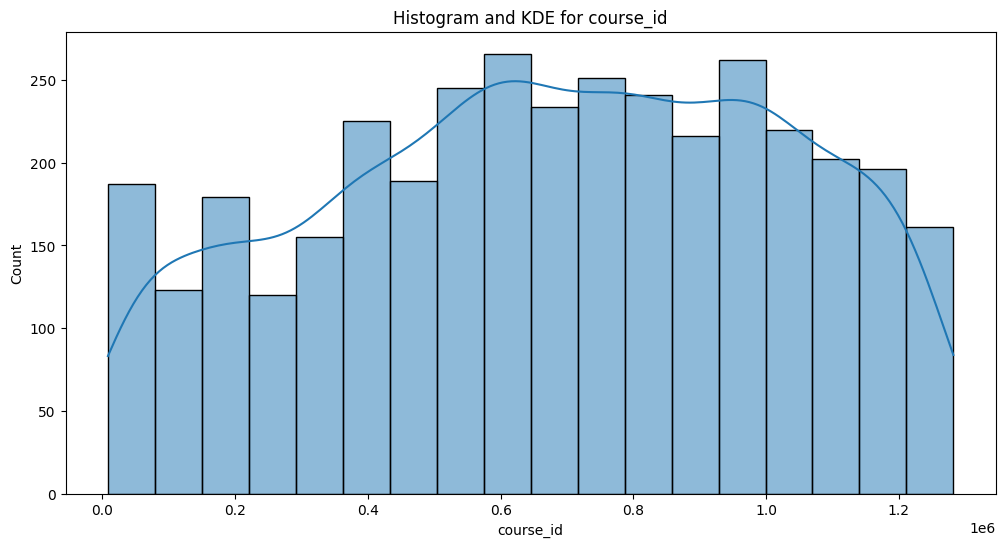

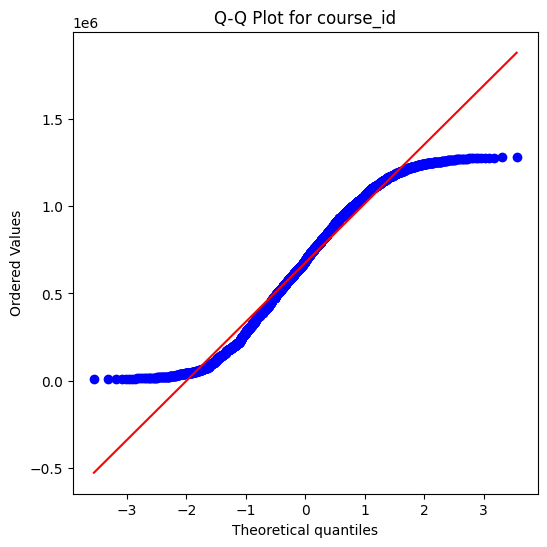

Shapiro-Wilk Test for course_id: p-value = 6.796295913549306e-28
course_id is not normally distributed.


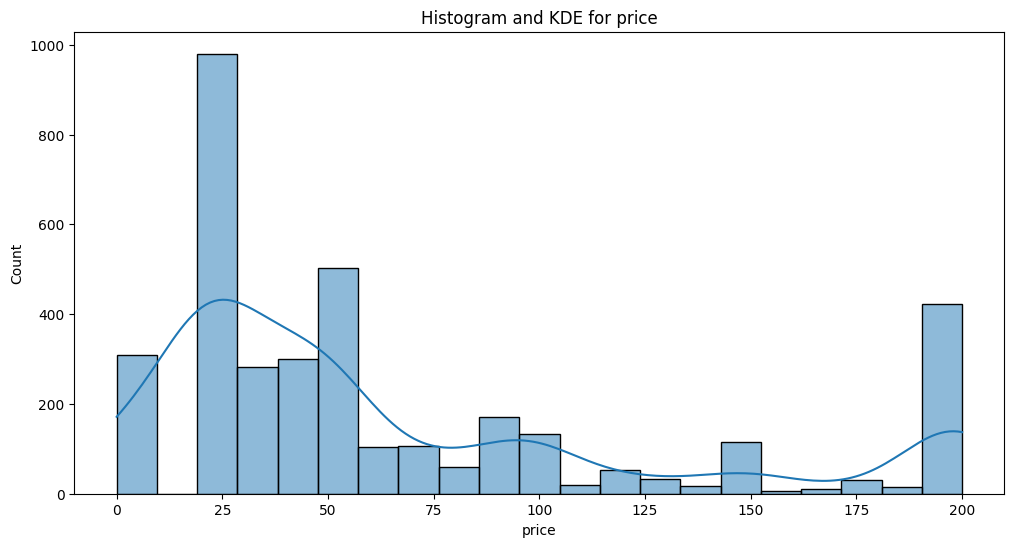

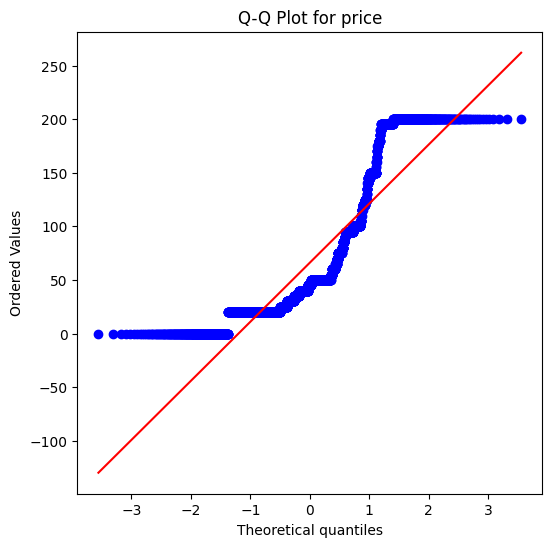

Shapiro-Wilk Test for price: p-value = 2.8372585758096045e-54
price is not normally distributed.


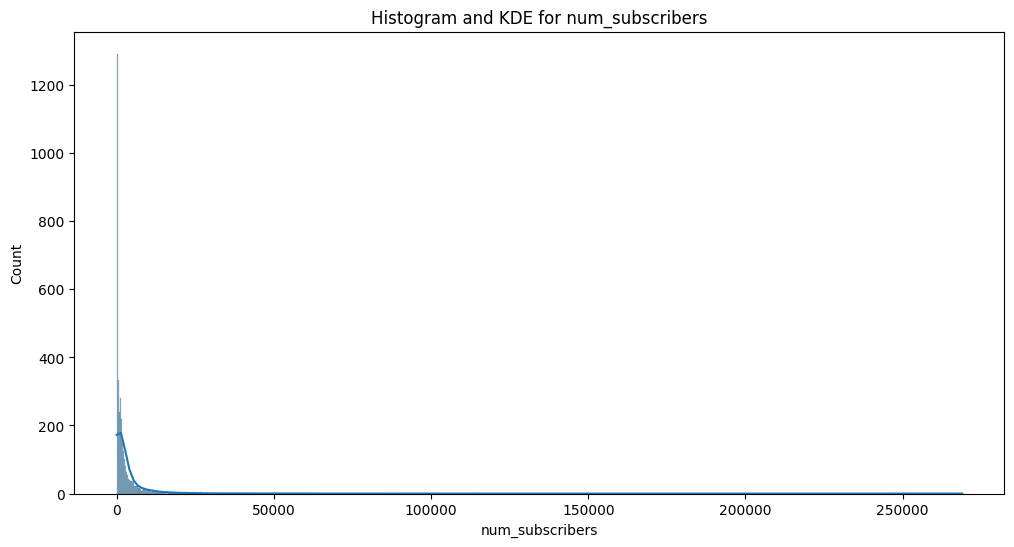

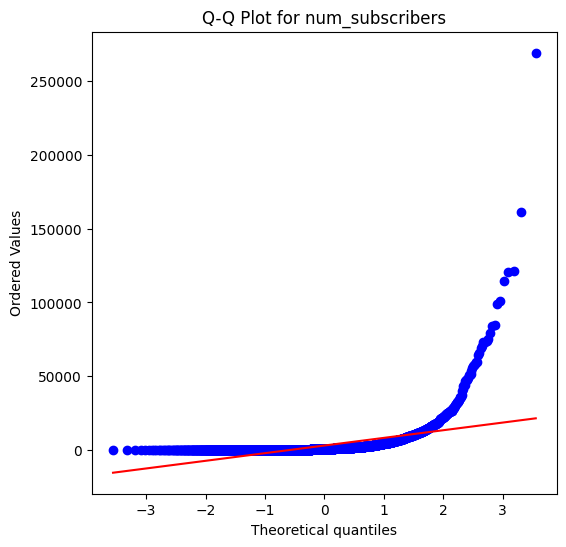

Shapiro-Wilk Test for num_subscribers: p-value = 6.259774597536059e-80
num_subscribers is not normally distributed.


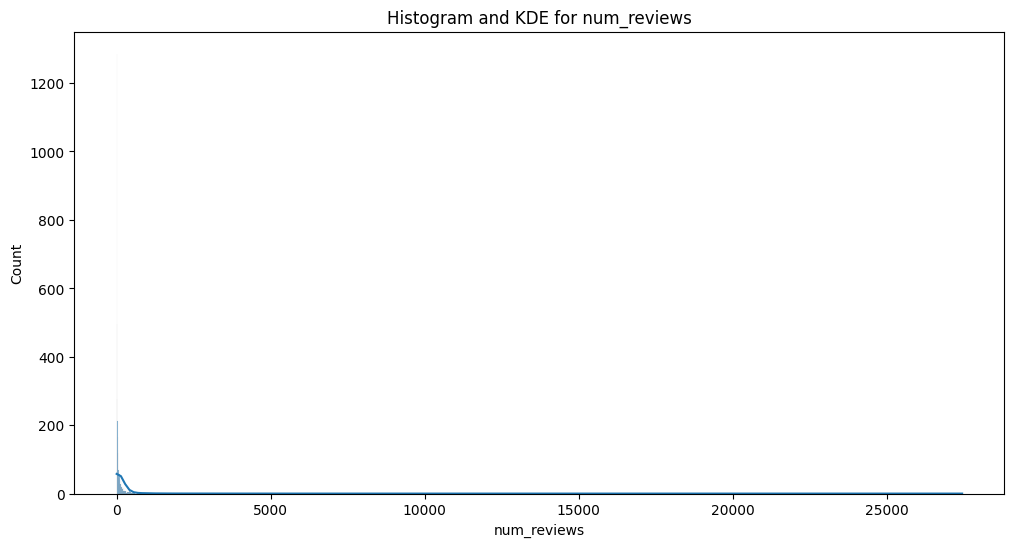

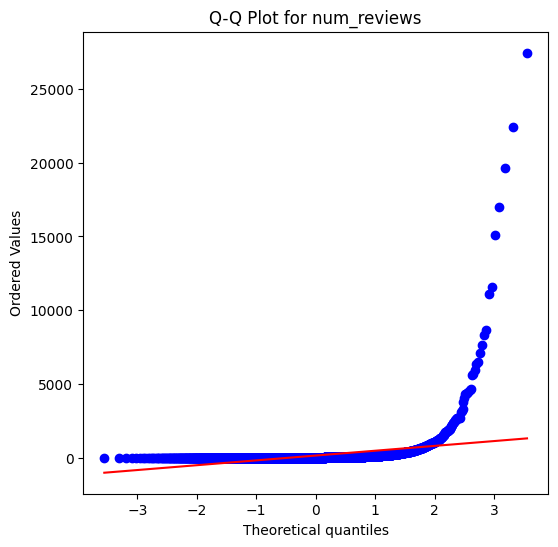

Shapiro-Wilk Test for num_reviews: p-value = 8.69796246968681e-85
num_reviews is not normally distributed.


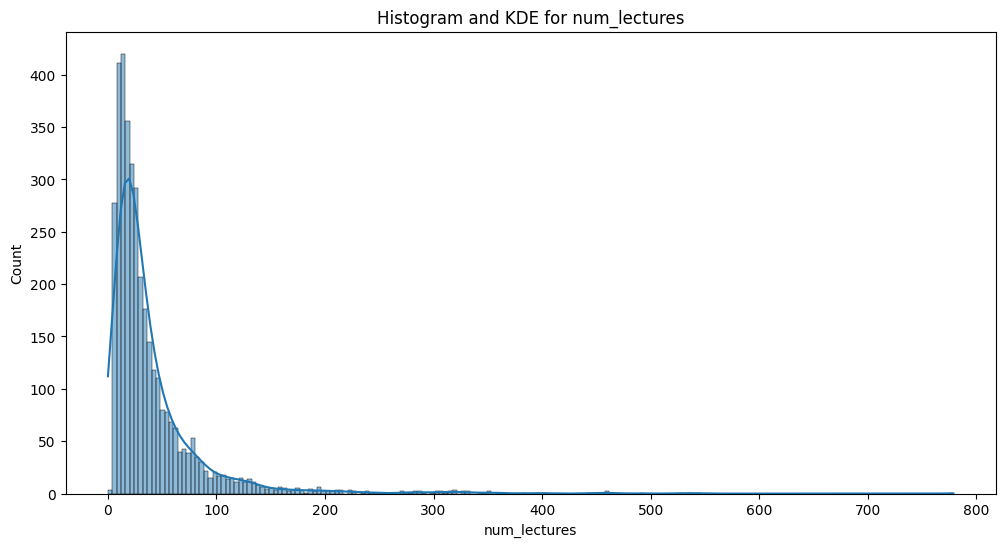

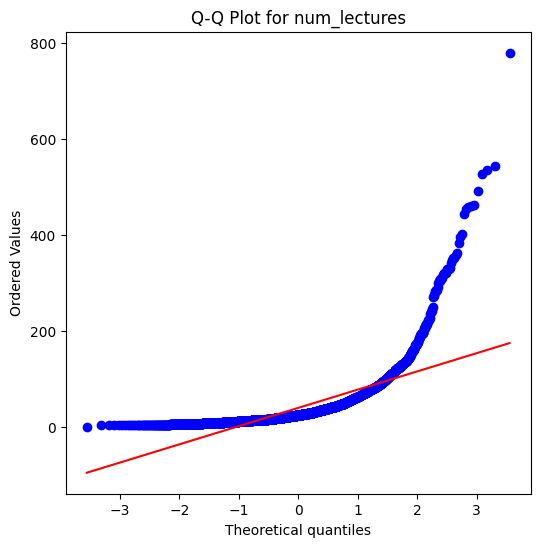

Shapiro-Wilk Test for num_lectures: p-value = 5.1278659913672285e-70
num_lectures is not normally distributed.


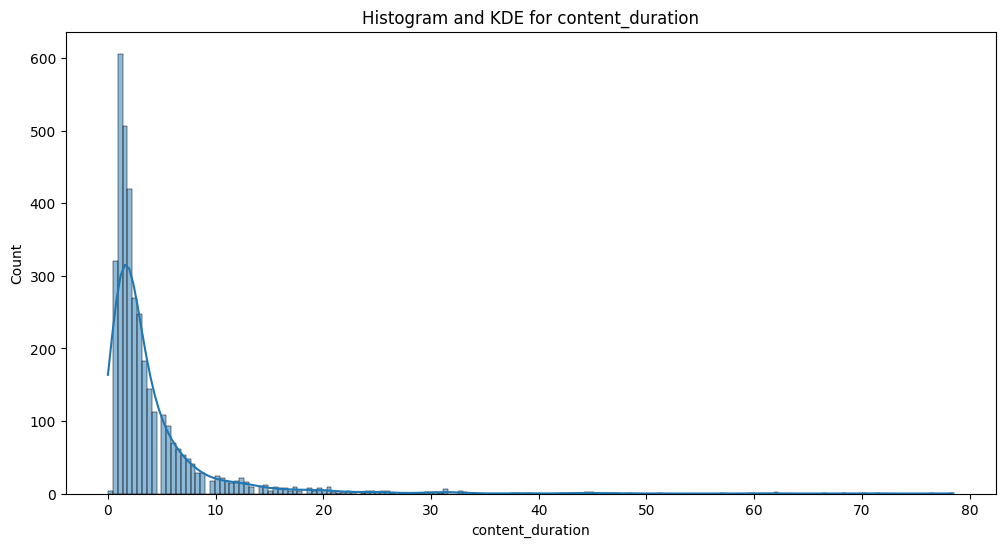

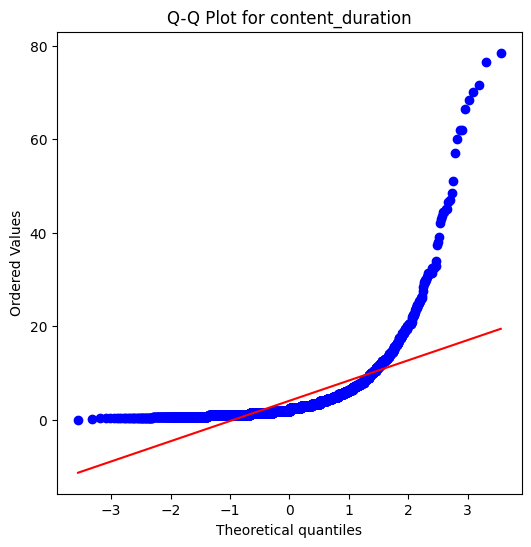

Shapiro-Wilk Test for content_duration: p-value = 1.8850432564997435e-72
content_duration is not normally distributed.


In [ ]:
for column in df.select_dtypes(include=['float64', 'int64']).columns:

    plt.figure(figsize=(12, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f"Histogram and KDE for {column}")
    plt.show()

    plt.figure(figsize=(6, 6))
    stats.probplot(df[column], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {column}")
    plt.show()

    stat, p_value = stats.shapiro(df[column])
    print(f"Shapiro-Wilk Test for {column}: p-value = {p_value}")

    if p_value < 0.05:
        print(f"{column} is not normally distributed.")
    else:
        print(f"{column} is normally distributed.")
